In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [15]:
train_data=pd.read_csv(r"C:\Users\agnes\Documents\apziva_ai_residency\project5\data\apple_train_data.csv")
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059410,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750252,132079200


In [20]:
train_data = train_data.set_index(['Date'])
#train_data = stock_data.set_index(['Date'])
#train_data.head()

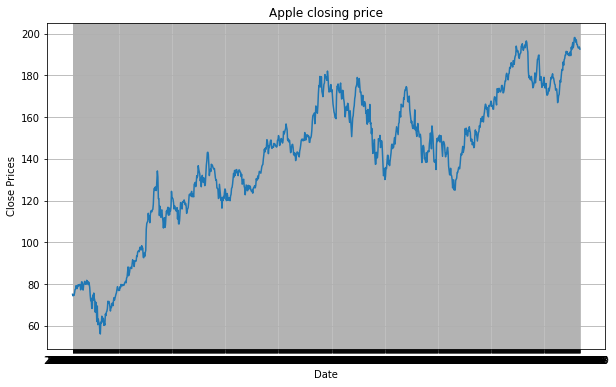

In [22]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train_data['Close'])
plt.title('Apple closing price')
plt.show()

<AxesSubplot: ylabel='Density'>

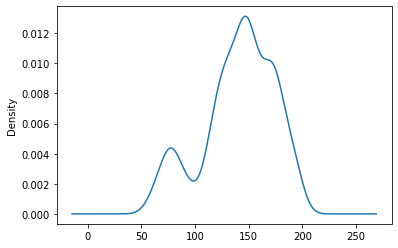

In [23]:

#Distribution of the dataset
df_close = train_data['Close']
df_close.plot(kind='kde')

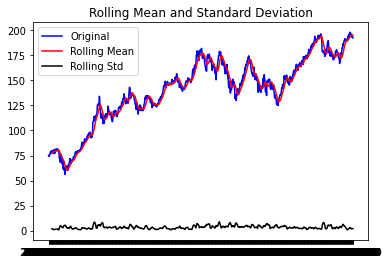

Results of dickey fuller test
Test Statistics                  -1.555344
p-value                           0.505978
No. of lags used                  0.000000
Number of observations used    1005.000000
critical value (1%)              -3.436873
critical value (5%)              -2.864420
critical value (10%)             -2.568304
dtype: float64


In [24]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # details dft
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

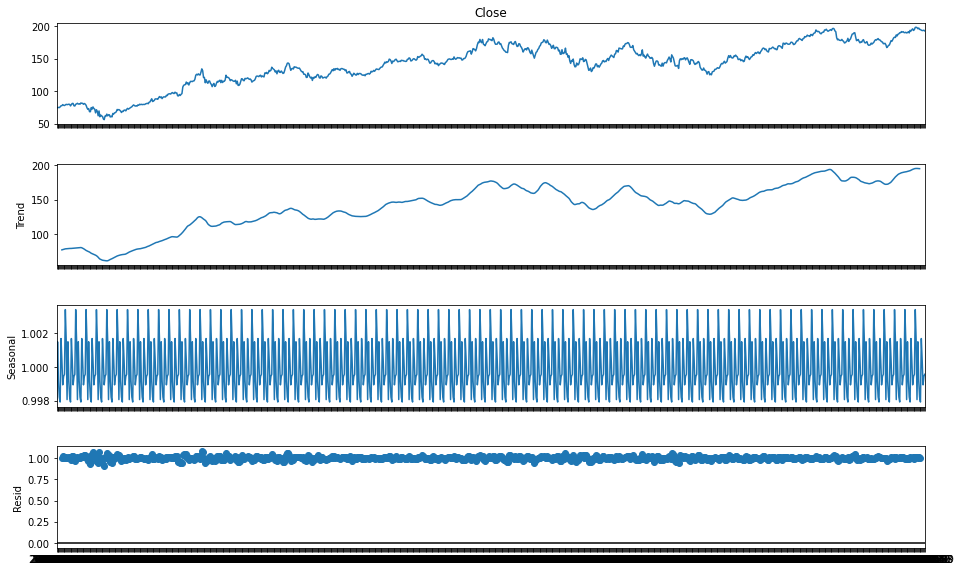

In [25]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


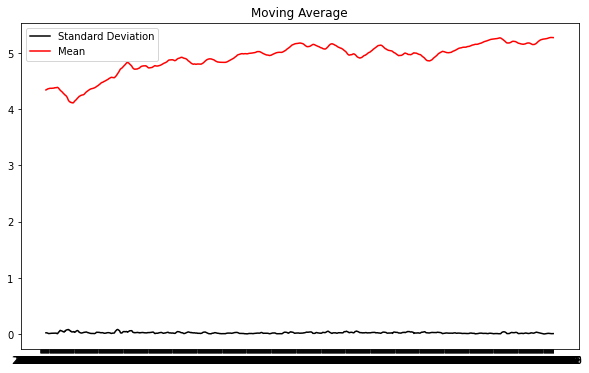

In [28]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4811.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4811.554, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4811.466, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4811.269, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4812.833, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2404.635
Date:                Sun, 21 Apr 2024   AIC                           4811.269
Time:                        18:34:34   BIC                           4816.182
Sample:                             0   HQIC                          4813.136
                               - 1006                                       

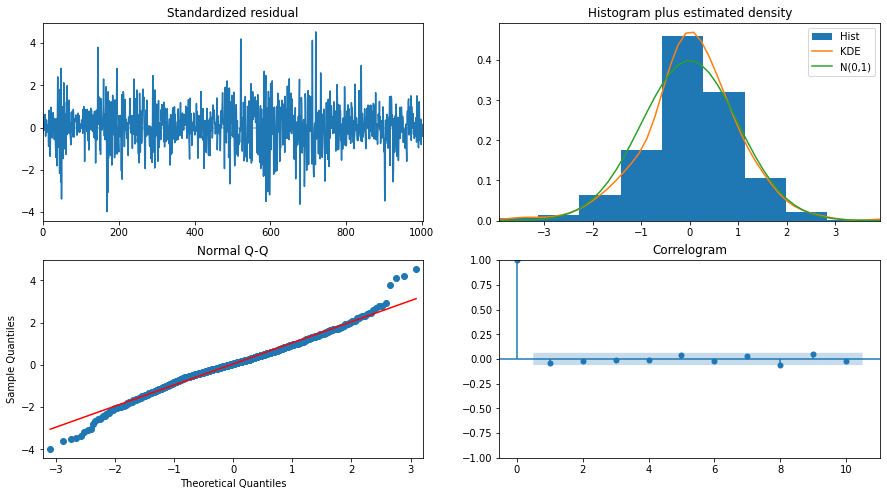

In [29]:

model_autoARIMA = auto_arima(train_data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [31]:
model = ARIMA(train_data['Close'], order=(2,1,0))
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1006
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2403.596
Date:                Sun, 21 Apr 2024   AIC                           4813.193
Time:                        18:37:32   BIC                           4827.931
Sample:                             0   HQIC                          4818.793
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0406      0.027     -1.518      0.129      -0.093       0.012
ar.L2         -0.0221      0.028     -0.799      0.424      -0.076       0.032
sigma2         6.9964      0.236     29.669      0.0

In [32]:

prediction = fitted.predict(199, 228)
len(prediction)

30